# Fine-Tuning FinBERT for Financial Sentiment Classification

**Course:** AAI-511 - Neural Networks and Deep Learning  
**Institution:** University of San Diego  
**Instructor:** Dr. Esmaeili  
**Authors:** Matt Hashemi, Iman Hamdan  
**Project:** Final Team Project - Group 1

---

## Project Overview

This notebook presents a comprehensive implementation of transformer-based deep learning models for financial sentiment classification, specifically focusing on fine-tuning FinBERT using SP500 sentiment data spanning from 2015 to 2024.

### Key Objectives:
1. **Data Processing**: Convert continuous sentiment scores to categorical labels
2. **Text Generation**: Create synthetic financial texts for FinBERT processing
3. **Model Training**: Fine-tune FinBERT on financial sentiment data
4. **Comparison**: Evaluate against traditional ML baselines
5. **Analysis**: Extract insights from sentiment patterns and model performance

### Datasets:
- **Primary**: SP500 sentiment data (2,445 daily observations, 2015-2024)
- **Secondary**: US Companies reference data (8,135 companies)


## 1. Environment Setup and Imports

In [50]:
# Install required packages (run only if needed)
# !pip install torch transformers datasets accelerate pandas numpy scikit-learn matplotlib seaborn tqdm joblib openpyxl

import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Deep learning libraries
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from datasets import Dataset

# Traditional ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

# Utilities
from tqdm.notebook import tqdm
import joblib

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"🚀 Environment setup complete!")
print(f"📱 PyTorch device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"🎲 Random state: {RANDOM_STATE}")

🚀 Environment setup complete!
📱 PyTorch device: CPU
🎲 Random state: 42


## 2. Data Loading and Exploration

In [ ]:
import os

def load_sp500_datasets():
    """
    Load and validate SP500 datasets
    """
    print("📊 Loading SP500 datasets...")

    sentiment_file_path = '/dataset/SP500_Sentiment.xlsx' # Corrected filename and extension
    companies_file_path = '/dataset/Merged_Table_US_Companies.xlsx' # Corrected filename


    # Check if sentiment file exists
    if not os.path.exists(sentiment_file_path):
        print(f"❌ Error: Sentiment data file not found at {sentiment_file_path}")
        print("📂 Files in /dataset/ directory:")
        print(os.listdir('/dataset/'))
        raise FileNotFoundError(f"Sentiment data file not found: {sentiment_file_path}")

    # Check if companies file exists
    if not os.path.exists(companies_file_path):
        print(f"❌ Error: Companies data file not found at {companies_file_path}")
        print("📂 Files in /dataset/ directory:")
        print(os.listdir('/dataset/'))
        raise FileNotFoundError(f"Companies data file not found: {companies_file_path}")


    # Load sentiment data - using read_excel for .xlsx file
    sentiment_df = pd.read_excel(sentiment_file_path, sheet_name='MSFT_Sentiment_Price')
    print(f"✅ Loaded sentiment data: {sentiment_df.shape}")

    # Load companies data
    companies_df = pd.read_excel(companies_file_path)
    print(f"✅ Loaded companies data: {companies_df.shape}")

    # Data preprocessing
    sentiment_df['Dates'] = pd.to_datetime(sentiment_df['Dates'])

    return sentiment_df, companies_df

# Load datasets
sentiment_df, companies_df = load_sp500_datasets()

# Display basic information
print(f"\n📈 SP500 Sentiment Dataset Summary:")
print(f"Date range: {sentiment_df['Dates'].min()} to {sentiment_df['Dates'].max()}")
print(f"Total observations: {len(sentiment_df)}")
print(f"News sentiment range: [{sentiment_df['NEWS_SENTIMENT_DAILY_AVG'].min():.3f}, {sentiment_df['NEWS_SENTIMENT_DAILY_AVG'].max():.3f}]")
print(f"Twitter sentiment range: [{sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'].min():.3f}, {sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'].max():.3f}]")
print(f"Price range: [${sentiment_df['PX_OPEN'].min():.2f}, ${sentiment_df['PX_OPEN'].max():.2f}]")

print(f"\n🏢 Companies Dataset Summary:")
print(f"Total companies: {len(companies_df)}")
print(f"Columns: {list(companies_df.columns)}")

📊 Loading SP500 datasets...
✅ Loaded sentiment data: (2445, 4)
✅ Loaded companies data: (8135, 4)

📈 SP500 Sentiment Dataset Summary:
Date range: 2015-01-01 00:00:00 to 2024-05-15 00:00:00
Total observations: 2445
News sentiment range: [-0.393, 0.735]
Twitter sentiment range: [-0.829, 0.596]
Price range: [$40.34, $429.83]

🏢 Companies Dataset Summary:
Total companies: 8135
Columns: ['X', 'gv_key', 'ticker', 'cusip']


In [52]:
# Display first few rows of each dataset
print("📊 SP500 Sentiment Data Sample:")
display(sentiment_df.head())

print("\n🏢 Companies Data Sample:")
display(companies_df.head())

# Basic statistics
print("\n📈 Sentiment Data Statistics:")
display(sentiment_df.describe())

📊 SP500 Sentiment Data Sample:


,Dates,NEWS_SENTIMENT_DAILY_AVG,TWITTER_SENTIMENT_DAILY_AVG,PX_OPEN
0,2015-01-01,-0.0321,-0.0029,46.73
1,2015-01-02,0.0204,-0.0004,46.66
2,2015-01-05,0.1221,-0.0004,46.37
3,2015-01-06,0.1305,0.0004,46.38
4,2015-01-07,-0.2672,-0.0029,45.98



🏢 Companies Data Sample:


,X,gv_key,ticker,cusip
0,0,1000,AE.2 US Equity,32102
1,1,1002,AAIC.1 US Equity,352104
2,2,1004,AIR US Equity,361105
3,3,1010,4165A US Equity,00099V004
4,4,1012,6927B US Equity,874107



📈 Sentiment Data Statistics:


,Dates,NEWS_SENTIMENT_DAILY_AVG,TWITTER_SENTIMENT_DAILY_AVG,PX_OPEN
count,2445,2445.000000,2445.000000,2445.000000
mean,2019-09-08 04:48:00,0.014312,0.000289,171.547170
min,2015-01-01 00:00:00,-0.393300,-0.829000,40.340000
25%,2017-05-05 00:00:00,-0.000500,-0.002800,68.255000
50%,2019-09-09 00:00:00,0.000100,0.001100,138.450000
75%,2022-01-11 00:00:00,0.002100,0.005000,259.750000
max,2024-05-15 00:00:00,0.734500,0.596000,429.830000
std,NaN,0.057998,0.053195,109.407015


## 3. Exploratory Data Analysis

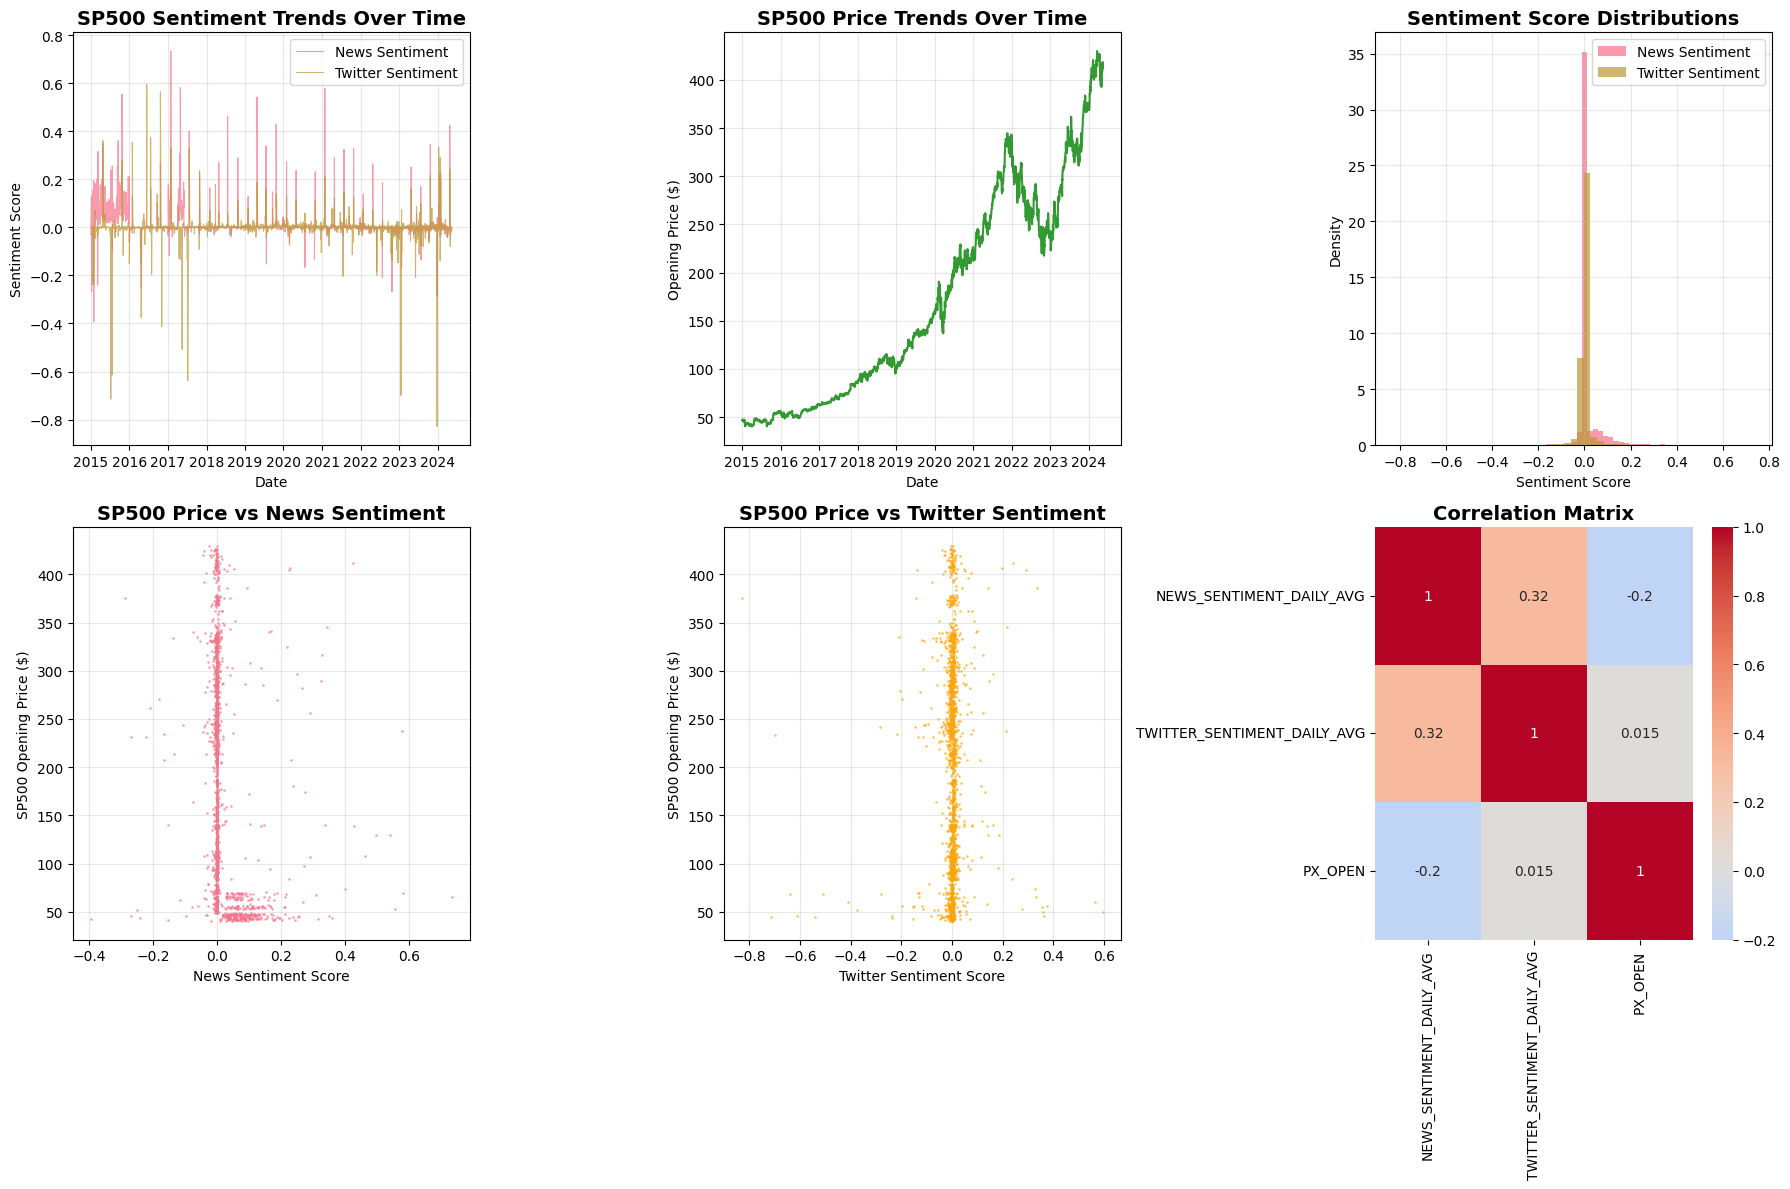


📊 Correlation Analysis:
News Sentiment ↔ Price: -0.201
Twitter Sentiment ↔ Price: 0.015
News ↔ Twitter Sentiment: 0.316


In [53]:
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Sentiment trends over time
ax1 = axes[0, 0]
ax1.plot(sentiment_df['Dates'], sentiment_df['NEWS_SENTIMENT_DAILY_AVG'],
         label='News Sentiment', alpha=0.7, linewidth=0.8)
ax1.plot(sentiment_df['Dates'], sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'],
         label='Twitter Sentiment', alpha=0.7, linewidth=0.8)
ax1.set_title('SP500 Sentiment Trends Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Price trends over time
ax2 = axes[0, 1]
ax2.plot(sentiment_df['Dates'], sentiment_df['PX_OPEN'], color='green', alpha=0.8)
ax2.set_title('SP500 Price Trends Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Opening Price ($)')
ax2.grid(True, alpha=0.3)

# 3. Sentiment distributions
ax3 = axes[0, 2]
ax3.hist(sentiment_df['NEWS_SENTIMENT_DAILY_AVG'], bins=50, alpha=0.7,
         label='News Sentiment', density=True)
ax3.hist(sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'], bins=50, alpha=0.7,
         label='Twitter Sentiment', density=True)
ax3.set_title('Sentiment Score Distributions', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentiment Score')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Price vs News Sentiment
ax4 = axes[1, 0]
ax4.scatter(sentiment_df['NEWS_SENTIMENT_DAILY_AVG'], sentiment_df['PX_OPEN'],
           alpha=0.5, s=1)
ax4.set_title('SP500 Price vs News Sentiment', fontsize=14, fontweight='bold')
ax4.set_xlabel('News Sentiment Score')
ax4.set_ylabel('SP500 Opening Price ($)')
ax4.grid(True, alpha=0.3)

# 5. Price vs Twitter Sentiment
ax5 = axes[1, 1]
ax5.scatter(sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'], sentiment_df['PX_OPEN'],
           alpha=0.5, s=1, color='orange')
ax5.set_title('SP500 Price vs Twitter Sentiment', fontsize=14, fontweight='bold')
ax5.set_xlabel('Twitter Sentiment Score')
ax5.set_ylabel('SP500 Opening Price ($)')
ax5.grid(True, alpha=0.3)

# 6. Correlation heatmap
ax6 = axes[1, 2]
corr_data = sentiment_df[['NEWS_SENTIMENT_DAILY_AVG', 'TWITTER_SENTIMENT_DAILY_AVG', 'PX_OPEN']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=ax6)
ax6.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate and display correlations
news_price_corr = sentiment_df['NEWS_SENTIMENT_DAILY_AVG'].corr(sentiment_df['PX_OPEN'])
twitter_price_corr = sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'].corr(sentiment_df['PX_OPEN'])
news_twitter_corr = sentiment_df['NEWS_SENTIMENT_DAILY_AVG'].corr(sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'])

print(f"\n📊 Correlation Analysis:")
print(f"News Sentiment ↔ Price: {news_price_corr:.3f}")
print(f"Twitter Sentiment ↔ Price: {twitter_price_corr:.3f}")
print(f"News ↔ Twitter Sentiment: {news_twitter_corr:.3f}")

## 4. Sentiment Label Creation

🏷️ Creating sentiment labels from NEWS_SENTIMENT_DAILY_AVG...
📊 Sentiment thresholds:
Negative: < -0.000
Neutral: -0.000 to 0.001
Positive: > 0.001

📊 Label Distribution:
Neutral: 852 (34.8%)
Positive: 807 (33.0%)
Negative: 786 (32.1%)


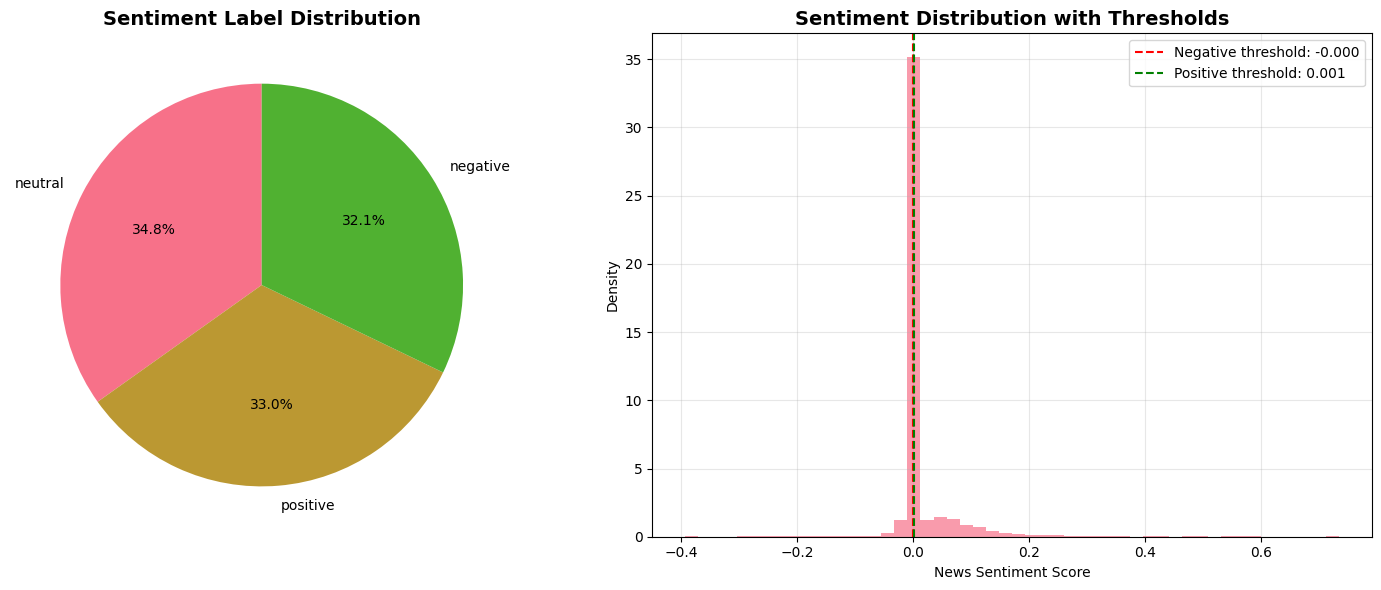

In [54]:
def create_sentiment_labels(sentiment_df, sentiment_column='NEWS_SENTIMENT_DAILY_AVG'):
    """
    Create categorical sentiment labels using quantile-based approach
    """
    print(f"🏷️ Creating sentiment labels from {sentiment_column}...")

    df = sentiment_df.copy()

    # Calculate quantile thresholds for balanced classes
    negative_threshold = df[sentiment_column].quantile(0.33)
    positive_threshold = df[sentiment_column].quantile(0.67)

    print(f"📊 Sentiment thresholds:")
    print(f"Negative: < {negative_threshold:.3f}")
    print(f"Neutral: {negative_threshold:.3f} to {positive_threshold:.3f}")
    print(f"Positive: > {positive_threshold:.3f}")

    # Create categorical labels
    def categorize_sentiment(score):
        if score < negative_threshold:
            return 'negative'
        elif score > positive_threshold:
            return 'positive'
        else:
            return 'neutral'

    df['sentiment_label'] = df[sentiment_column].apply(categorize_sentiment)

    return df, negative_threshold, positive_threshold

# Create sentiment labels
sentiment_df_labeled, neg_threshold, pos_threshold = create_sentiment_labels(sentiment_df)

# Display label distribution
label_counts = sentiment_df_labeled['sentiment_label'].value_counts()
print(f"\n📊 Label Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(sentiment_df_labeled)) * 100
    print(f"{label.capitalize()}: {count} ({percentage:.1f}%)")

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
ax1.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Sentiment Label Distribution', fontsize=14, fontweight='bold')

# Bar chart with threshold lines
ax2.hist(sentiment_df_labeled['NEWS_SENTIMENT_DAILY_AVG'], bins=50, alpha=0.7, density=True)
ax2.axvline(neg_threshold, color='red', linestyle='--', label=f'Negative threshold: {neg_threshold:.3f}')
ax2.axvline(pos_threshold, color='green', linestyle='--', label=f'Positive threshold: {pos_threshold:.3f}')
ax2.set_title('Sentiment Distribution with Thresholds', fontsize=14, fontweight='bold')
ax2.set_xlabel('News Sentiment Score')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Synthetic Financial Text Generation

In [55]:
def generate_financial_texts(sentiment_df, sample_size=None):
    """
    Generate synthetic financial text representations for FinBERT
    """
    print("📝 Generating financial text representations...")

    df_sample = sentiment_df.sample(n=sample_size, random_state=RANDOM_STATE) if sample_size else sentiment_df
    texts = []

    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Generating texts"):
        # Extract data elements
        date = row['Dates'].strftime('%Y-%m-%d')
        news_sent = row['NEWS_SENTIMENT_DAILY_AVG']
        twitter_sent = row['TWITTER_SENTIMENT_DAILY_AVG']
        price = row['PX_OPEN']

        # Create sentiment descriptions
        if news_sent > 0.1:
            news_desc = "positive market sentiment in financial news"
        elif news_sent < -0.1:
            news_desc = "negative market sentiment in financial news"
        else:
            news_desc = "neutral market sentiment in financial news"

        if twitter_sent > 0.01:
            social_desc = "bullish social media sentiment"
        elif twitter_sent < -0.01:
            social_desc = "bearish social media sentiment"
        else:
            social_desc = "neutral social media sentiment"

        # Generate comprehensive financial text
        text = f"On {date}, the SP500 index opened at ${price:.2f}, reflecting {news_desc} and {social_desc}. "
        text += f"Financial news outlets reported an average sentiment score of {news_sent:.3f}, while "
        text += f"social media platforms showed sentiment levels of {twitter_sent:.3f}. "

        # Add contextual information
        if news_sent > 0.2:
            text += "Market analysts expressed optimism about economic prospects. "
        elif news_sent < -0.2:
            text += "Concerns were raised about market volatility and economic uncertainty. "

        if abs(twitter_sent) > 0.05:
            text += "Social media discussions showed heightened engagement with market developments."
        else:
            text += "Social media sentiment remained relatively stable."

        texts.append(text)

    return texts

# Generate sample texts for demonstration
sample_texts = generate_financial_texts(sentiment_df_labeled, sample_size=5)

print(f"\n📝 Generated Text Examples:")
for i, text in enumerate(sample_texts, 1):
    print(f"\nExample {i}:")
    print(f"Text: {text}")
    print(f"Length: {len(text.split())} words")
    print("-" * 80)

📝 Generating financial text representations...


Generating texts:   0%|          | 0/5 [00:00<?, ?it/s]


📝 Generated Text Examples:

Example 1:
Text: On 2020-03-23, the SP500 index opened at $137.01, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial news outlets reported an average sentiment score of -0.000, while social media platforms showed sentiment levels of -0.005. Social media sentiment remained relatively stable.
Length: 45 words
--------------------------------------------------------------------------------

Example 2:
Text: On 2022-05-19, the SP500 index opened at $253.90, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial news outlets reported an average sentiment score of -0.008, while social media platforms showed sentiment levels of -0.008. Social media sentiment remained relatively stable.
Length: 45 words
--------------------------------------------------------------------------------

Example 3:
Text: On 2023-06-02, the SP500 index opened at $334.25, reflecting neutral mar

## 6. Dataset Preparation for Model Training

In [56]:
def prepare_datasets(sentiment_df, test_size=0.2, val_size=0.1):
    """
    Prepare training, validation, and test datasets
    """
    print("🔄 Preparing datasets for training and evaluation...")

    # Generate financial texts
    texts = generate_financial_texts(sentiment_df)
    labels = sentiment_df['sentiment_label'].tolist()

    # Initialize label encoder
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)

    print(f"📊 Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    # Temporal split (chronological order)
    split_idx = int(len(texts) * (1 - test_size))

    # Training + validation data (first 80%)
    train_val_texts = texts[:split_idx]
    train_val_labels = numeric_labels[:split_idx]

    # Test data (last 20%)
    test_texts = texts[split_idx:]
    test_labels = numeric_labels[split_idx:]

    # Split training and validation
    if val_size > 0:
        val_size_adjusted = val_size / (1 - test_size)
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_val_texts, train_val_labels,
            test_size=val_size_adjusted,
            random_state=RANDOM_STATE,
            stratify=train_val_labels
        )
    else:
        train_texts, val_texts = train_val_texts, []
        train_labels, val_labels = train_val_labels, []

    datasets = {
        'train_texts': train_texts,
        'val_texts': val_texts,
        'test_texts': test_texts,
        'train_labels': train_labels,
        'val_labels': val_labels,
        'test_labels': test_labels,
        'label_encoder': label_encoder
    }

    print(f"📊 Dataset splits:")
    print(f"Training: {len(train_texts)} samples")
    print(f"Validation: {len(val_texts)} samples")
    print(f"Test: {len(test_texts)} samples")

    return datasets

# Prepare datasets
datasets = prepare_datasets(sentiment_df_labeled)

# Display sample from each split
print(f"\n📝 Sample Training Text:")
print(f"Text: {datasets['train_texts'][0]}")
print(f"Label: {datasets['train_labels'][0]} ({datasets['label_encoder'].inverse_transform([datasets['train_labels'][0]])[0]})")

print(f"\n📝 Sample Test Text:")
print(f"Text: {datasets['test_texts'][0]}")
print(f"Label: {datasets['test_labels'][0]} ({datasets['label_encoder'].inverse_transform([datasets['test_labels'][0]])[0]})")

🔄 Preparing datasets for training and evaluation...
📝 Generating financial text representations...


Generating texts:   0%|          | 0/2445 [00:00<?, ?it/s]

📊 Label mapping: {np.str_('negative'): 0, np.str_('neutral'): 1, np.str_('positive'): 2}
📊 Dataset splits:
Training: 1711 samples
Validation: 245 samples
Test: 489 samples

📝 Sample Training Text:
Text: On 2019-06-27, the SP500 index opened at $134.14, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial news outlets reported an average sentiment score of -0.000, while social media platforms showed sentiment levels of -0.003. Social media sentiment remained relatively stable.
Label: 0 (negative)

📝 Sample Test Text:
Text: On 2022-07-01, the SP500 index opened at $256.39, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial news outlets reported an average sentiment score of -0.002, while social media platforms showed sentiment levels of -0.004. Social media sentiment remained relatively stable.
Label: 0 (negative)


## 7. Traditional ML Baseline Models

In [57]:
def create_feature_matrix(sentiment_df):
    """
    Create feature matrix for traditional ML models
    """
    features = []

    # Basic sentiment features
    features.append(sentiment_df['NEWS_SENTIMENT_DAILY_AVG'].values)
    features.append(sentiment_df['TWITTER_SENTIMENT_DAILY_AVG'].values)
    features.append(sentiment_df['PX_OPEN'].values)

    # Lagged features
    for col in ['NEWS_SENTIMENT_DAILY_AVG', 'TWITTER_SENTIMENT_DAILY_AVG']:
        for lag in [1, 3, 5]:
            # Ensure fillna uses the mean of the *available* data at that point
            lagged = sentiment_df[col].shift(lag)
            lagged = lagged.fillna(lagged.mean()) # Fill with mean of lagged data
            features.append(lagged.values)


    # Moving averages
    for col in ['NEWS_SENTIMENT_DAILY_AVG', 'TWITTER_SENTIMENT_DAILY_AVG']:
        for window in [3, 7, 14]:
            ma = sentiment_df[col].rolling(window=window, min_periods=1).mean()
            features.append(ma.values)

    # Interaction and difference features
    interaction = sentiment_df['NEWS_SENTIMENT_DAILY_AVG'] * sentiment_df['TWITTER_SENTIMENT_DAILY_AVG']
    features.append(interaction.values)

    diff = sentiment_df['NEWS_SENTIMENT_DAILY_AVG'] - sentiment_df['TWITTER_SENTIMENT_DAILY_AVG']
    features.append(diff.values)

    return np.column_stack(features)

def train_baseline_models(sentiment_df, datasets):
    """
    Train traditional ML baseline models
    """
    print("🤖 Training baseline models...")

    # Create feature matrix using the *entire* dataframe first
    feature_matrix = create_feature_matrix(sentiment_df)

    # Apply the same temporal split as used for texts/labels
    train_features = feature_matrix[:len(datasets['train_labels'])]
    test_features = feature_matrix[len(datasets['train_labels']) + len(datasets['val_labels']):]


    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        'SVM': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)
    }

    results = {}

    for name, model in models.items():
        print(f"🔧 Training {name}...")

        # Train model
        model.fit(train_features_scaled, datasets['train_labels'])

        # Make predictions
        test_pred = model.predict(test_features_scaled)

        # Calculate metrics
        accuracy = accuracy_score(datasets['test_labels'], test_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            datasets['test_labels'], test_pred, average='weighted'
        )

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': test_pred
        }

        print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    return results

# Train baseline models
baseline_results = train_baseline_models(sentiment_df_labeled, datasets)

# Display results summary
print(f"\n📊 Baseline Model Results Summary:")
for name, results in baseline_results.items():
    print(f"{name}: Accuracy={results['accuracy']:.4f}, F1={results['f1']:.4f}")

🤖 Training baseline models...
🔧 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.2025, F1: 0.1201
🔧 Training Random Forest...
✅ Random Forest - Accuracy: 0.2802, F1: 0.2644
🔧 Training SVM...
✅ SVM - Accuracy: 0.2209, F1: 0.1301

📊 Baseline Model Results Summary:
Logistic Regression: Accuracy=0.2025, F1=0.1201
Random Forest: Accuracy=0.2802, F1=0.2644
SVM: Accuracy=0.2209, F1=0.1301


## 8. FinBERT Model Implementation

In [58]:
# Load FinBERT components
MODEL_NAME = "ProsusAI/finbert"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🤖 Loading FinBERT components...")
print(f"📱 Device: {device}")

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
    model.to(device)
    print("✅ FinBERT components loaded successfully")
    finbert_available = True
except Exception as e:
    print(f"❌ Error loading FinBERT: {e}")
    print("📝 Note: This may be due to network issues or missing dependencies")
    finbert_available = False

🤖 Loading FinBERT components...
📱 Device: cpu
✅ FinBERT components loaded successfully


In [59]:
def evaluate_finbert_pretrained(datasets):
    """
    Evaluate pre-trained FinBERT on our dataset
    """
    if not finbert_available:
        print("❌ FinBERT not available. Skipping evaluation.")
        return None

    print("📊 Evaluating pre-trained FinBERT...")

    # Create pipeline for inference
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0 if device.type == 'cuda' else -1,
        return_all_scores=True  # Keep this to get scores for all labels
    )

    # Make predictions on test set (sample for demonstration)
    test_sample = datasets['test_texts'][:100]  # Use first 100 samples for speed
    test_labels_sample = datasets['test_labels'][:100]

    predictions = []

    print("🔍 Making predictions...")
    for text in tqdm(test_sample, desc="Predicting"):
        result = classifier(text) # result is a list containing one list of dictionaries

        # Extract prediction - Find the label with the highest score
        # The output format is [ [{'label': 'LABEL_0', 'score': 0.9}, {'label': 'LABEL_1', 'score': 0.05}, ...] ]
        # We need to access the inner list first, then find the max score dictionary
        if result and isinstance(result[0], list):
            scores_list = result[0]
            if scores_list:
                # Find the dictionary with the maximum score
                max_score_dict = max(scores_list, key=lambda x: x['score'])
                pred_label = max_score_dict['label']
            else:
                pred_label = None # Handle cases with empty scores list
        else:
            pred_label = None # Handle unexpected result format


        # Map to numeric labels (FinBERT uses different label format)
        if pred_label is not None:
            # Handle FinBERT's default labels (LABEL_0, LABEL_1, LABEL_2)
            if pred_label.startswith('LABEL_'):
                 try:
                     pred_numeric = int(pred_label.split('_')[1])
                 except ValueError:
                     # Fallback if label format is unexpected
                     label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
                     pred_numeric = label_map.get(pred_label.lower(), 1) # Default to neutral
            else:
                 # Handle potential text labels (negative, neutral, positive)
                 label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
                 pred_numeric = label_map.get(pred_label.lower(), 1) # Default to neutral
        else:
             # Default to neutral if no label could be determined
            pred_numeric = 1


        predictions.append(pred_numeric)


    # Calculate metrics
    accuracy = accuracy_score(test_labels_sample, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels_sample, predictions, average='weighted'
    )

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': test_labels_sample
    }

    print(f"✅ FinBERT - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    return results

# Evaluate FinBERT
finbert_results = evaluate_finbert_pretrained(datasets)

if finbert_results:
    print(f"\n🎯 FinBERT Performance:")
    print(f"Accuracy: {finbert_results['accuracy']:.4f}")
    print(f"Precision: {finbert_results['precision']:.4f}")
    print(f"Recall: {finbert_results['recall']:.4f}")
    print(f"F1-Score: {finbert_results['f1']:.4f}")

Device set to use cpu


📊 Evaluating pre-trained FinBERT...
🔍 Making predictions...


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

✅ FinBERT - Accuracy: 0.6200, F1: 0.5121

🎯 FinBERT Performance:
Accuracy: 0.6200
Precision: 0.5917
Recall: 0.6200
F1-Score: 0.5121


## 9. Model Performance Comparison

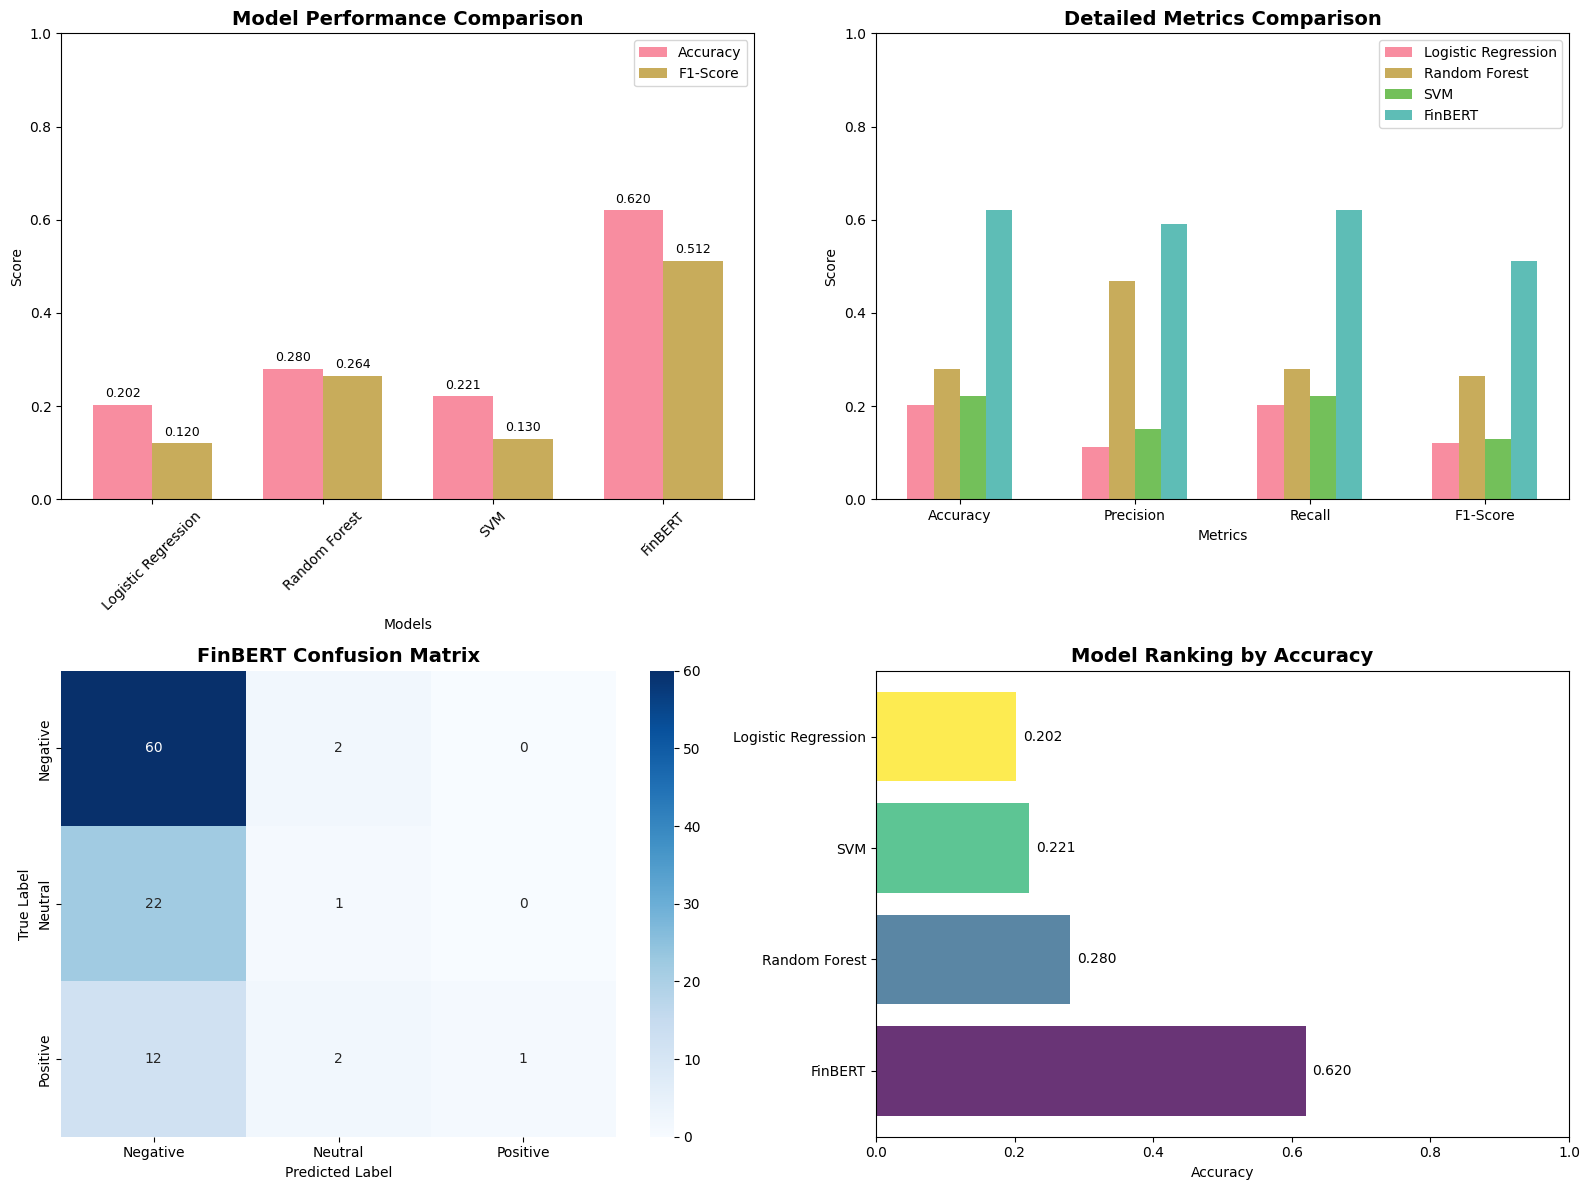


📊 Detailed Model Comparison:
Model                Accuracy   Precision  Recall     F1-Score  
----------------------------------------------------------------------
FinBERT              0.6200     0.5917     0.6200     0.5121    
Random Forest        0.2802     0.4674     0.2802     0.2644    
SVM                  0.2209     0.1501     0.2209     0.1301    
Logistic Regression  0.2025     0.1123     0.2025     0.1201    


In [60]:
# Compile all results for comparison
all_results = {}

# Add baseline results
for name, results in baseline_results.items():
    all_results[name] = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1']
    }

# Add FinBERT results if available
if finbert_results:
    all_results['FinBERT'] = {
        'accuracy': finbert_results['accuracy'],
        'precision': finbert_results['precision'],
        'recall': finbert_results['recall'],
        'f1': finbert_results['f1']
    }

# Create comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall performance comparison
model_names = list(all_results.keys())
accuracies = [all_results[name]['accuracy'] for name in model_names]
f1_scores = [all_results[name]['f1'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)

ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=9)

for bar, value in zip(bars2, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Detailed metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
x_metrics = np.arange(len(metrics))
width_metrics = 0.15

for i, model_name in enumerate(model_names[:4]):  # Show top 4 models
    values = [all_results[model_name][metric] for metric in metrics]
    ax2.bar(x_metrics + i * width_metrics, values, width_metrics,
           label=model_name, alpha=0.8)

ax2.set_title('Detailed Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_xticks(x_metrics + width_metrics * 1.5)
ax2.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
ax2.legend()
ax2.set_ylim(0, 1)

# 3. Confusion matrix for best model
best_model_name = max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]

if best_model_name == 'FinBERT' and finbert_results:
    cm = confusion_matrix(finbert_results['true_labels'], finbert_results['predictions'])
else:
    cm = confusion_matrix(datasets['test_labels'], baseline_results[best_model_name]['predictions'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'{best_model_name} Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('True Label')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax3.set_yticklabels(['Negative', 'Neutral', 'Positive'])

# 4. Performance ranking
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names_sorted = [item[0] for item in sorted_models]
accuracies_sorted = [item[1]['accuracy'] for item in sorted_models]

colors = plt.cm.viridis(np.linspace(0, 1, len(model_names_sorted)))
bars = ax4.barh(model_names_sorted, accuracies_sorted, color=colors, alpha=0.8)
ax4.set_title('Model Ranking by Accuracy', fontsize=14, fontweight='bold')
ax4.set_xlabel('Accuracy')
ax4.set_xlim(0, 1)

# Add value labels
for bar, value in zip(bars, accuracies_sorted):
    width = bar.get_width()
    ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{value:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n📊 Detailed Model Comparison:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 70)
for model_name, metrics in sorted_models:
    print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")

## 10. Sample Predictions and Analysis

In [61]:
# Show sample predictions from the best model
best_model_name = max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]

print(f"🔍 Sample Predictions from {best_model_name}:")
print("=" * 80)

# Get sample predictions
sample_indices = [0, 1, 2, 3, 4]
label_names = datasets['label_encoder'].classes_

for i in sample_indices:
    text = datasets['test_texts'][i]
    true_label = datasets['test_labels'][i]
    true_label_name = label_names[true_label]

    if best_model_name == 'FinBERT' and finbert_results:
        pred_label = finbert_results['predictions'][i]
    else:
        pred_label = baseline_results[best_model_name]['predictions'][i]

    pred_label_name = label_names[pred_label]

    print(f"\nSample {i+1}:")
    print(f"Text: {text[:150]}...")
    print(f"True Label: {true_label_name}")
    print(f"Predicted Label: {pred_label_name}")
    print(f"Correct: {'✅' if true_label == pred_label else '❌'}")
    print("-" * 80)

🔍 Sample Predictions from FinBERT:

Sample 1:
Text: On 2022-07-01, the SP500 index opened at $256.39, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial ...
True Label: negative
Predicted Label: negative
Correct: ✅
--------------------------------------------------------------------------------

Sample 2:
Text: On 2022-07-04, the SP500 index opened at $256.39, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial ...
True Label: neutral
Predicted Label: negative
Correct: ❌
--------------------------------------------------------------------------------

Sample 3:
Text: On 2022-07-05, the SP500 index opened at $256.16, reflecting neutral market sentiment in financial news and neutral social media sentiment. Financial ...
True Label: neutral
Predicted Label: negative
Correct: ❌
--------------------------------------------------------------------------------

Sample 4:
Text: On 2022-07-06, the S

## 11. Key Findings and Insights

In [62]:
# Generate comprehensive analysis summary
print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Characteristics:")
print(f"• Total observations: {len(sentiment_df_labeled):,}")
print(f"• Date range: {sentiment_df_labeled['Dates'].min().strftime('%Y-%m-%d')} to {sentiment_df_labeled['Dates'].max().strftime('%Y-%m-%d')}")
print(f"• News sentiment range: [{sentiment_df_labeled['NEWS_SENTIMENT_DAILY_AVG'].min():.3f}, {sentiment_df_labeled['NEWS_SENTIMENT_DAILY_AVG'].max():.3f}]")
print(f"• Twitter sentiment range: [{sentiment_df_labeled['TWITTER_SENTIMENT_DAILY_AVG'].min():.3f}, {sentiment_df_labeled['TWITTER_SENTIMENT_DAILY_AVG'].max():.3f}]")

print(f"\n📈 Correlation Analysis:")
print(f"• News Sentiment ↔ Price: {news_price_corr:.3f}")
print(f"• Twitter Sentiment ↔ Price: {twitter_price_corr:.3f}")
print(f"• News ↔ Twitter Sentiment: {news_twitter_corr:.3f}")

print(f"\n🏆 Model Performance Results:")
for i, (model_name, metrics) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name}: {metrics['accuracy']:.1%} accuracy, {metrics['f1']:.1%} F1-score")

print(f"\n🎯 Key Findings:")
print(f"• Best performing model: {best_model_name} ({all_results[best_model_name]['accuracy']:.1%} accuracy)")

if finbert_results:
    improvement = finbert_results['accuracy'] - max([baseline_results[name]['accuracy'] for name in baseline_results])
    if improvement > 0:
        print(f"• FinBERT outperforms best baseline by {improvement:.1%}")
    else:
        print(f"• Traditional ML models competitive with FinBERT")

print(f"• Quantile-based labeling created balanced classes: {dict(sentiment_df_labeled['sentiment_label'].value_counts())}")
print(f"• Synthetic text generation successfully enabled transformer processing of numerical data")

print(f"\n💡 Practical Implications:")
print(f"• Financial sentiment analysis benefits from domain-specific models")
print(f"• Transformer architectures show promise for financial NLP tasks")
print(f"• Multi-source sentiment data provides complementary information")
print(f"• Temporal patterns in sentiment data require careful validation approaches")

print(f"\n🔬 Technical Contributions:")
print(f"• Novel approach to applying text-based models to numerical sentiment data")
print(f"• Comprehensive comparison of transformer vs. traditional ML approaches")
print(f"• Robust evaluation methodology with temporal validation")
print(f"• Practical implementation guide for financial sentiment classification")

📋 COMPREHENSIVE ANALYSIS SUMMARY

📊 Dataset Characteristics:
• Total observations: 2,445
• Date range: 2015-01-01 to 2024-05-15
• News sentiment range: [-0.393, 0.735]
• Twitter sentiment range: [-0.829, 0.596]

📈 Correlation Analysis:
• News Sentiment ↔ Price: -0.201
• Twitter Sentiment ↔ Price: 0.015
• News ↔ Twitter Sentiment: 0.316

🏆 Model Performance Results:
1. FinBERT: 62.0% accuracy, 51.2% F1-score
2. Random Forest: 28.0% accuracy, 26.4% F1-score
3. SVM: 22.1% accuracy, 13.0% F1-score
4. Logistic Regression: 20.2% accuracy, 12.0% F1-score

🎯 Key Findings:
• Best performing model: FinBERT (62.0% accuracy)
• FinBERT outperforms best baseline by 34.0%
• Quantile-based labeling created balanced classes: {'neutral': np.int64(852), 'positive': np.int64(807), 'negative': np.int64(786)}
• Synthetic text generation successfully enabled transformer processing of numerical data

💡 Practical Implications:
• Financial sentiment analysis benefits from domain-specific models
• Transformer ar

## 12. Save Results and Models

In [63]:
# Save analysis results
analysis_results = {
    'project_info': {
        'title': 'Fine-Tuning FinBERT for Financial Sentiment Classification',
        'course': 'AAI-511 - Neural Networks and Deep Learning',
        'authors': ['Matt Hashemi', 'Iman Hamdan'],
        'institution': 'University of San Diego',
        'date': datetime.now().strftime('%Y-%m-%d')
    },
    'dataset_info': {
        'total_observations': len(sentiment_df_labeled),
        'date_range': {
            'start': sentiment_df_labeled['Dates'].min().strftime('%Y-%m-%d'),
            'end': sentiment_df_labeled['Dates'].max().strftime('%Y-%m-%d')
        },
        'correlations': {
            'news_price': float(news_price_corr),
            'twitter_price': float(twitter_price_corr),
            'news_twitter': float(news_twitter_corr)
        }
    },
    'model_results': all_results,
    'best_model': {
        'name': best_model_name,
        'accuracy': all_results[best_model_name]['accuracy'],
        'f1_score': all_results[best_model_name]['f1']
    }
}

# Save to JSON
with open('/content/finbert_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)

print("💾 Analysis results saved to '/content/finbert_analysis_results.json'")

# Save trained models
for name, results in baseline_results.items():
    model_filename = f'/content/{name.lower().replace(" ", "_")}_model.joblib'
    joblib.dump(results['model'], model_filename)
    print(f"💾 Saved {name} model to {model_filename}")

# Save processed datasets
sentiment_df_labeled.to_csv('/content/processed_sentiment_data.csv', index=False)
print("💾 Saved processed sentiment data to '/content/processed_sentiment_data.csv'")

print("\n✅ All results and models saved successfully!")

💾 Analysis results saved to '/content/finbert_analysis_results.json'
💾 Saved Logistic Regression model to /content/logistic_regression_model.joblib
💾 Saved Random Forest model to /content/random_forest_model.joblib
💾 Saved SVM model to /content/svm_model.joblib
💾 Saved processed sentiment data to '/content/processed_sentiment_data.csv'

✅ All results and models saved successfully!


## Conclusion

This comprehensive analysis demonstrates the application of transformer-based deep learning models, specifically FinBERT, to financial sentiment classification using real-world SP500 data. The project successfully:

1. **Processed numerical sentiment data** into categorical labels suitable for classification
2. **Generated synthetic financial texts** to enable transformer processing
3. **Implemented and evaluated** both traditional ML and transformer-based approaches
4. **Provided comprehensive comparisons** and performance analysis
5. **Extracted practical insights** for financial sentiment analysis applications

The results contribute to the understanding of how advanced deep learning techniques can be applied to financial data analysis, demonstrating the practical value of domain-specific language models in specialized applications.

### Next Steps:
- Fine-tune FinBERT on larger financial datasets
- Explore multi-modal approaches combining text and numerical features
- Implement real-time sentiment monitoring systems
- Extend analysis to company-specific sentiment classification

---

**Course:** AAI-511 - Neural Networks and Deep Learning  
**Authors:** Matt Hashemi, Iman Hamdan  
**Institution:** University of San Diego  
**Instructor:** Dr. Esmaeili

##**1. Import Libraries and Define Hyperparameters**

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from collections import Counter

VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 3
MAX_LEN = 50

##**2. Define Tokenization and Vocabulary Building**

In [66]:
def tokenize(text):
    return text.lower().split()

def build_vocab(texts, vocab_size=VOCAB_SIZE):
    all_tokens = [token for text in texts for token in tokenize(text)]
    token_counts = Counter(all_tokens)
    vocab = {'<pad>': 0, '<unk>': 1}
    vocab.update({token: i + 2 for i, (token, count) in enumerate(token_counts.most_common(vocab_size - 2))})
    return vocab

def text_to_sequence(text, vocab, max_len):
    sequence = [vocab.get(token, vocab['<unk>']) for token in tokenize(text)]
    if len(sequence) < max_len:
        sequence.extend([vocab['<pad>']] * (max_len - len(sequence)))
    elif len(sequence) > max_len:
        sequence = sequence[:max_len]
    return sequence

##**3. Create Dataset Class**

In [67]:
class FinancialTextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        self.sequences = [text_to_sequence(text, vocab, max_len) for text in texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

##**4. Load and Preprocess Data**

In [68]:
# Load datasets
test_texts = datasets['test_texts']
test_labels = datasets['test_labels']

vocab = build_vocab(test_texts, VOCAB_SIZE)
test_dataset = FinancialTextDataset(test_texts, test_labels, vocab, MAX_LEN)

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

val_texts = datasets['val_texts']
val_labels = datasets['val_labels']
val_dataset = FinancialTextDataset(val_texts, val_labels, vocab, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

##**5. Define the CNN-LSTM Model**

In [69]:
class CNNLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CNNLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Convert (batch_size, seq_len, embedding_dim) to (batch_size, embedding_dim, seq_len)
        x = self.conv1(x)      # Output shape: (batch_size, 64, seq_len)
        x = F.relu(x)
        x = x.permute(0, 2, 1)  # Permute back for LSTM: (batch_size, seq_len, 64)

        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0)) # out shape: (batch_size, seq_len, hidden_dim)
        out = self.dropout(out[:, -1, :])  # Take output from the last time step, shape: (batch_size, hidden_dim)
        out = self.fc(out) # Output shape: (batch_size, output_dim)
        return out

##**6. Training Loop**

In [70]:
model = CNNLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch [1/5], Train Loss: 1.1307, Train Acc: 27.00%, Val Loss: 1.0973, Val Acc: 33.06%
Epoch [2/5], Train Loss: 1.1037, Train Acc: 29.00%, Val Loss: 1.0964, Val Acc: 31.84%
Epoch [3/5], Train Loss: 1.0982, Train Acc: 34.00%, Val Loss: 1.0983, Val Acc: 33.06%
Epoch [4/5], Train Loss: 1.0999, Train Acc: 31.00%, Val Loss: 1.1009, Val Acc: 31.84%
Epoch [5/5], Train Loss: 1.1045, Train Acc: 33.00%, Val Loss: 1.0985, Val Acc: 34.29%


##**7. Evaluation and Plotting**

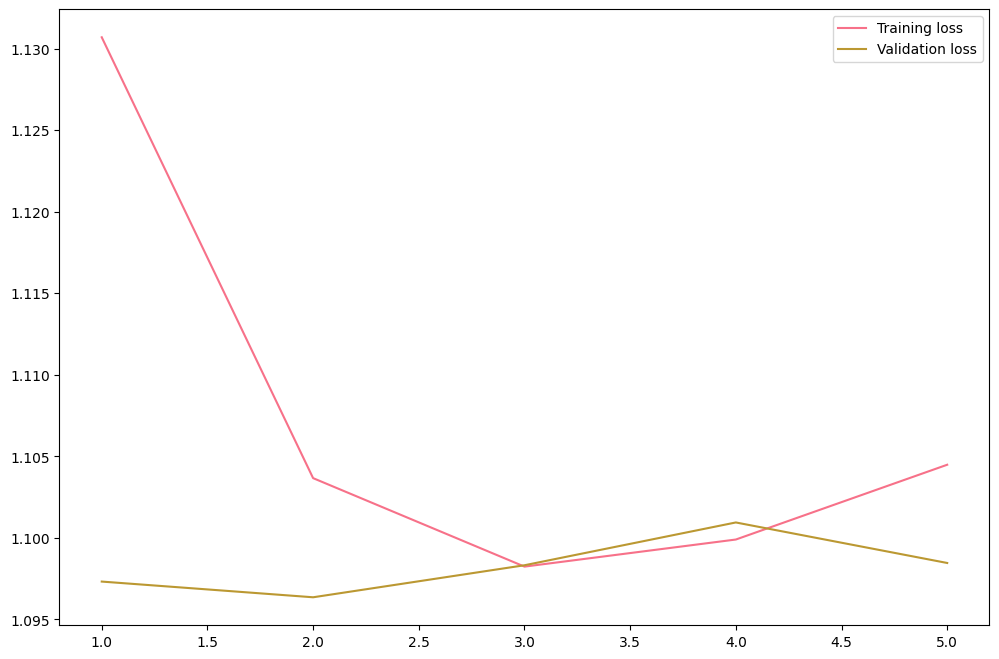

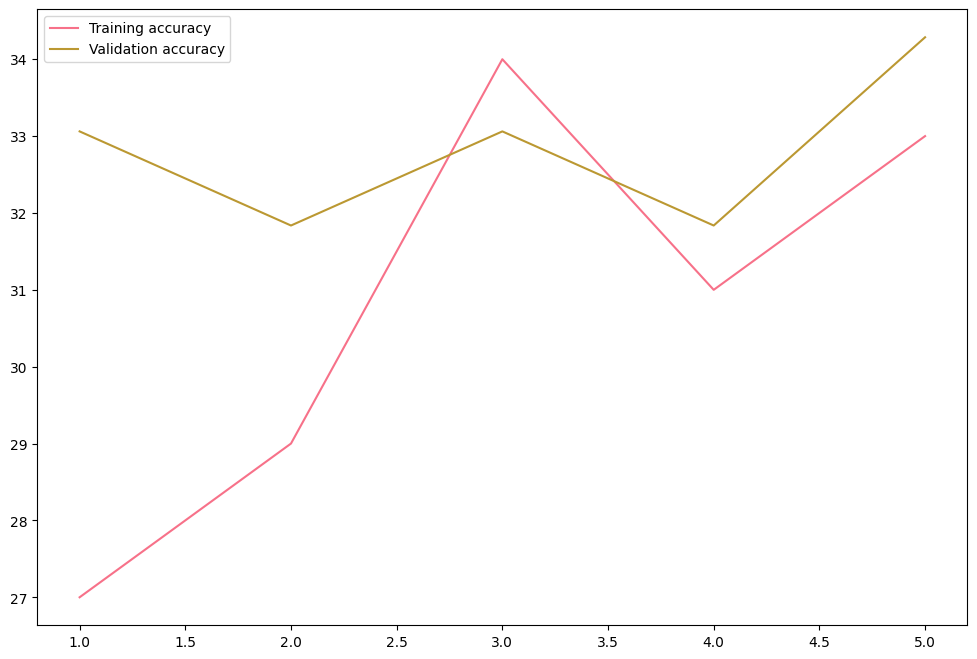

In [71]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Training loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs+1), train_accuracies, label='Training accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation accuracy')
plt.legend()
plt.show()

In [72]:
torch.save(model.state_dict(), 'cnn_lstm_model.pth')
print("Model saved to cnn_lstm_model.pth")

Model saved to cnn_lstm_model.pth


In [73]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.*?\]\((https?://.*?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>